Initial State:
│ Current Time       │ Time Until End     │   
│          0         │         870        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     1    90   278 |     2   305   603 |     3   649   788 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2      -      -     - |     4   135   324 |     5   369   651 |     6   714   892 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   1.00     51   715 |     7   270   568 |     8   640   704 |     9   714   855 |     -     -

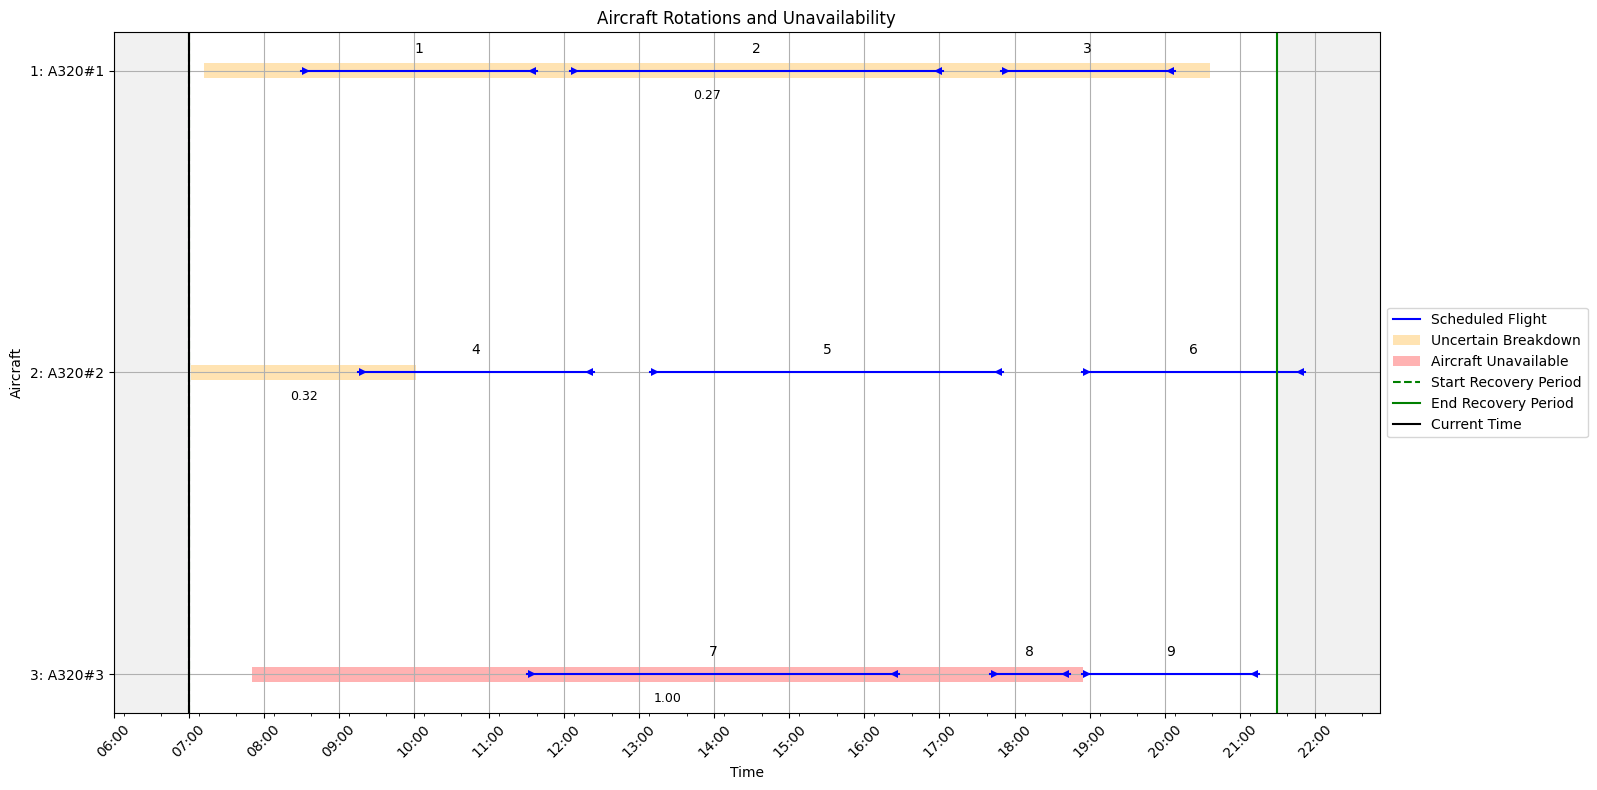

Action taken: Flight 9, Aircraft 0, Reward: -1005

Step 1:


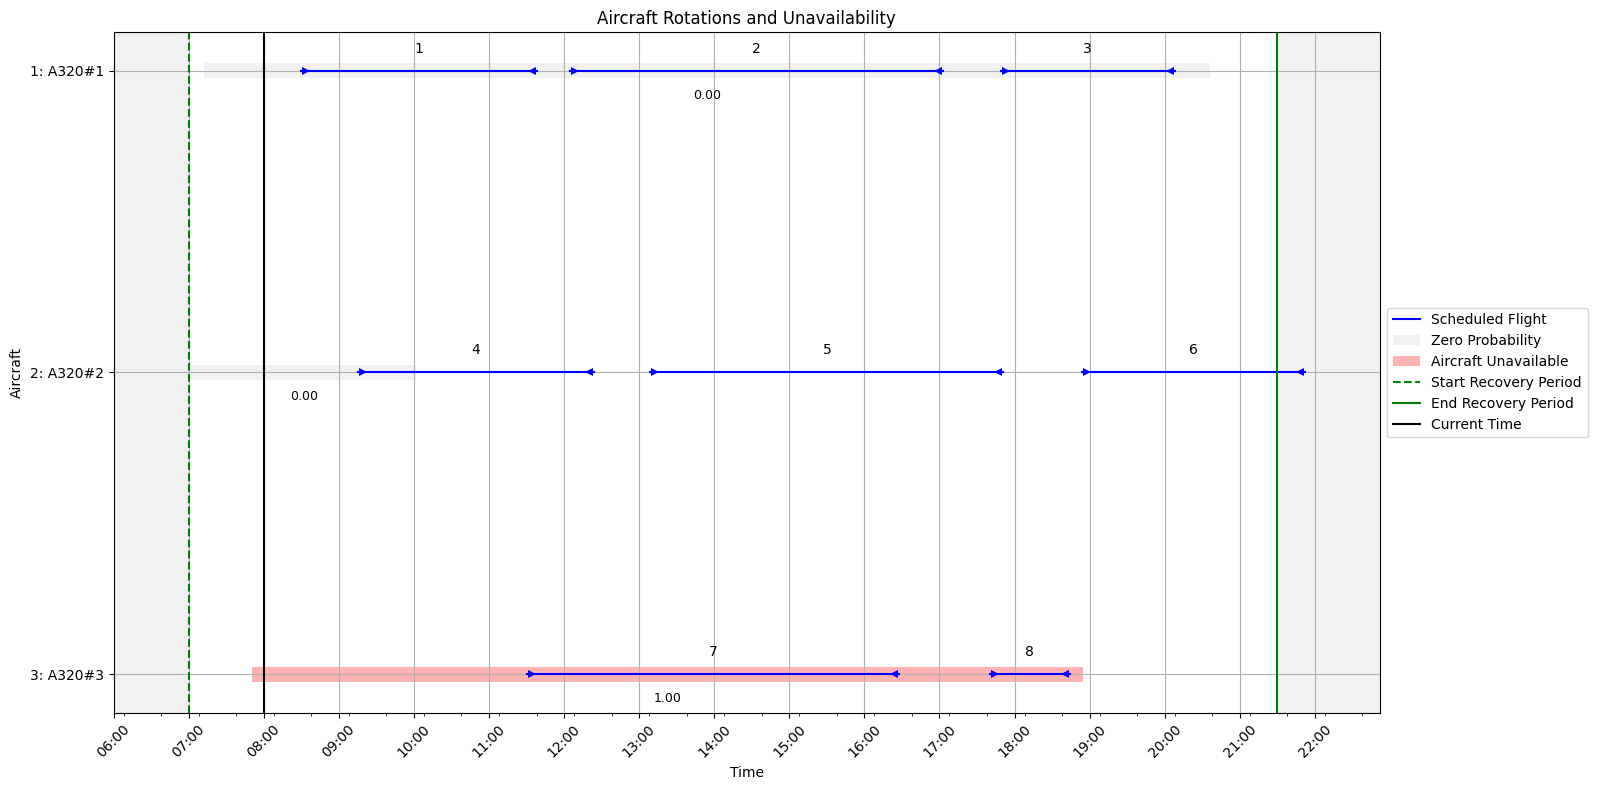


=== Starting schedule_flight_on_aircraft ===
Scheduling flight 6 on aircraft A320#1
Initial dep_time: 714.0, arr_time: 892.0
Original departure minutes: 714.0
Flight duration: 178.0
****Current aircraft ID:
A320#2

Unavailability check:
Current aircraft: A320#2, Target aircraft: A320#1
Unavailability - Start: 12.0, End: 816.0, Prob: 0.0

Flight overlaps with unavailability period!
Flight times - Dep: 714.0, Arr: 892.0
Unavail times - Start: 12.0, End: 816.0
Case 4: Different aircraft with prob < 1.00 - Allowing overlap
Delayed departure time for flight 6 to 788.0 minutes due to conflict.
Delayed arrival time for flight 6 to 966.0 minutes.
Final departure time for flight 6: 788.0 minutes.
Final arrival time for flight 6: 966.0 minutes.
Action taken: Flight 6, Aircraft 1, Reward: -444.0

Step 2:


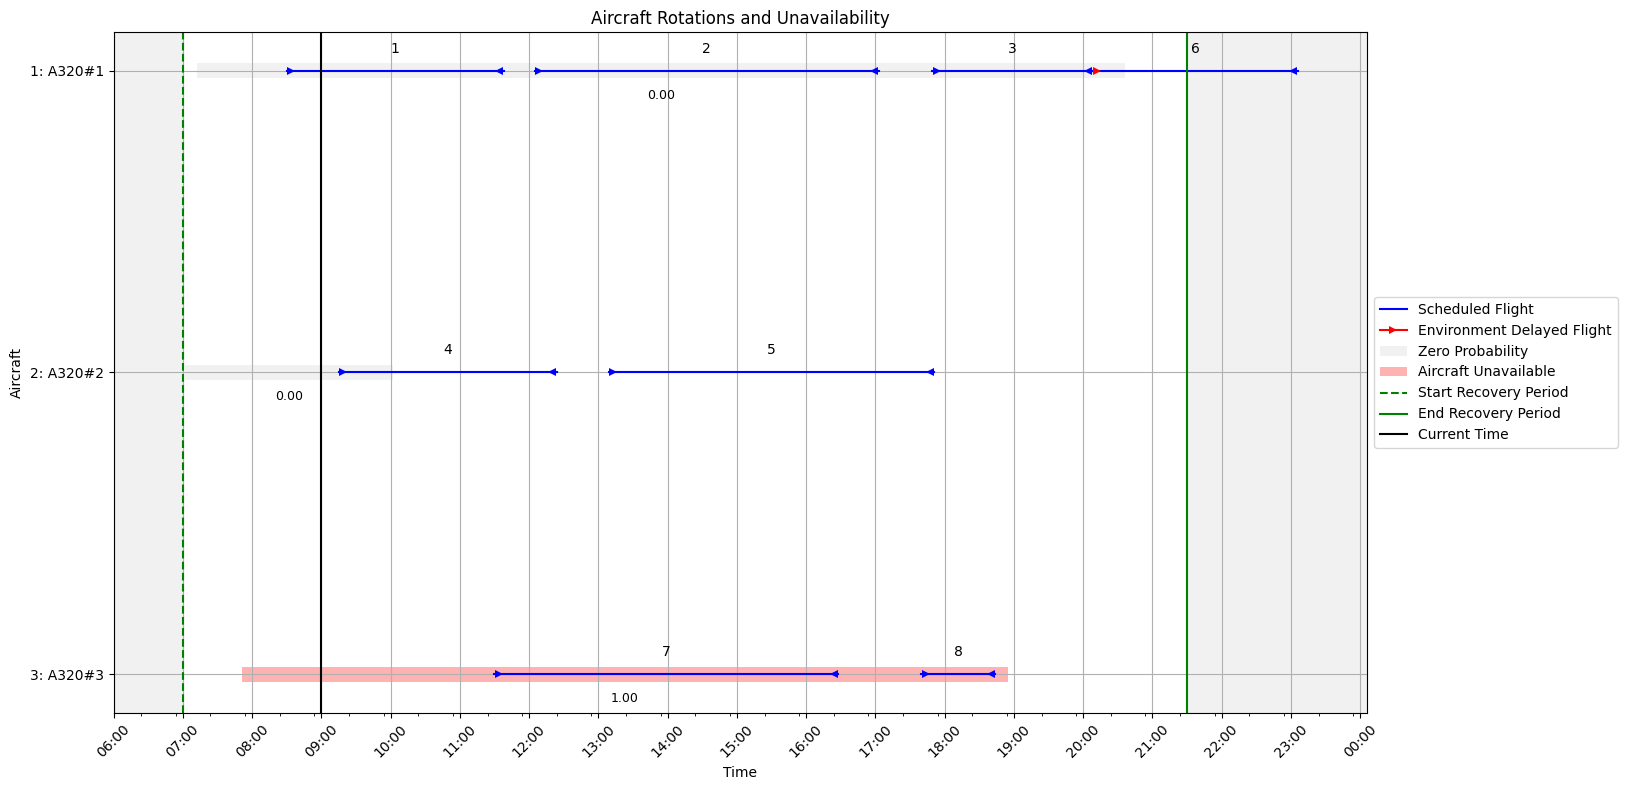


=== Starting schedule_flight_on_aircraft ===
Scheduling flight 3 on aircraft A320#3
Initial dep_time: 649.0, arr_time: 788.0
Original departure minutes: 649.0
Flight duration: 139.0
****Current aircraft ID:
A320#1

Unavailability check:
Current aircraft: A320#1, Target aircraft: A320#3
Unavailability - Start: 51.0, End: 715.0, Prob: 1.0

Flight overlaps with unavailability period!
Flight times - Dep: 649.0, Arr: 788.0
Unavail times - Start: 51.0, End: 715.0
Case 3: Different aircraft with prob = 1.00 - Moving flight after unavailability
Final departure time for flight 3: 715.0 minutes.
Final arrival time for flight 3: 854.0 minutes.
Action taken: Flight 3, Aircraft 3, Reward: -396.0

Step 3:


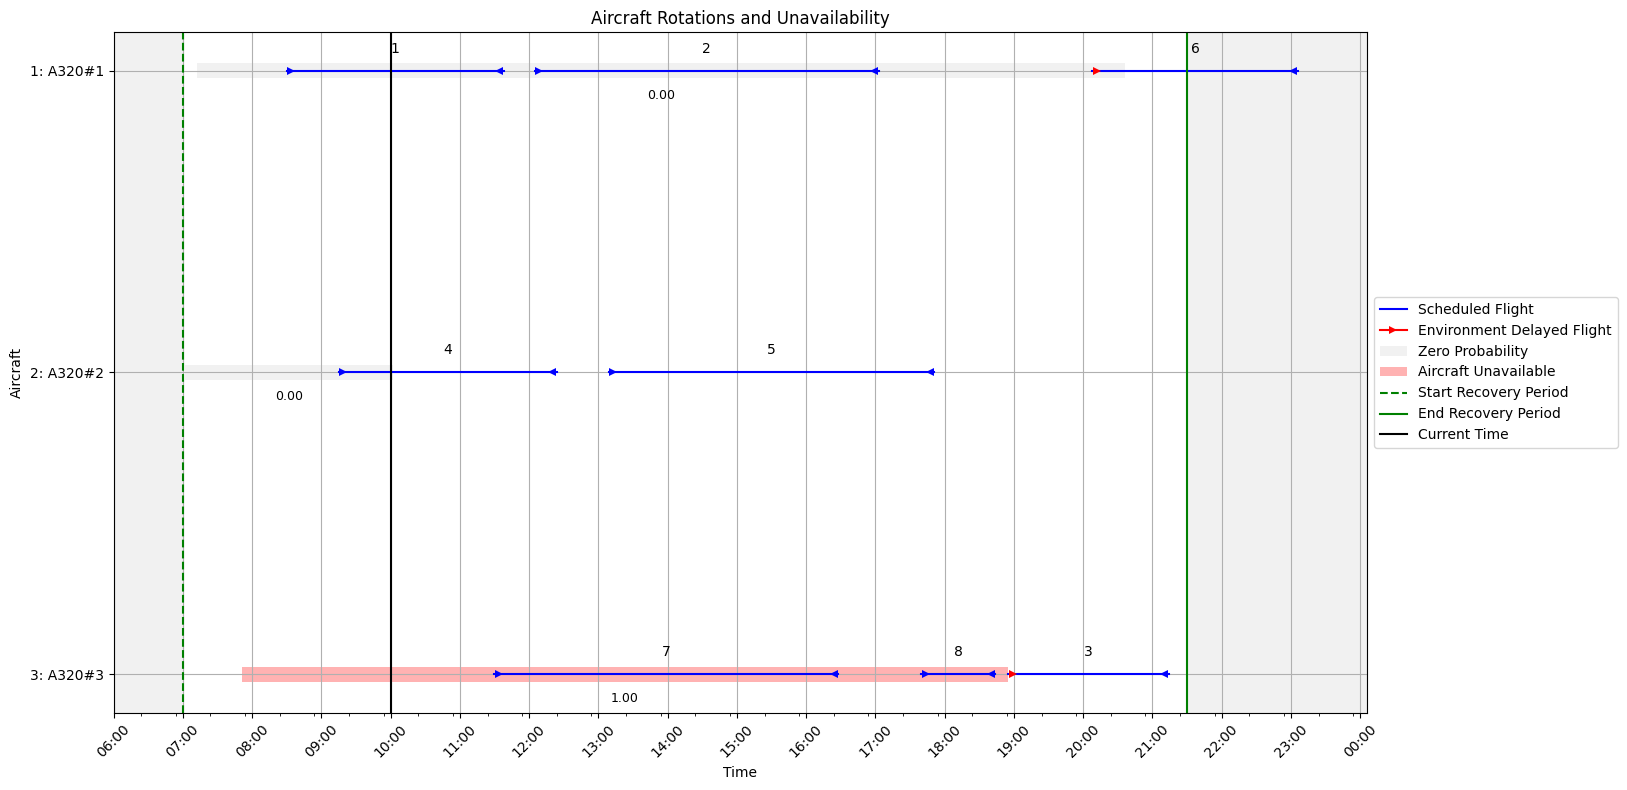


=== Starting schedule_flight_on_aircraft ===
Scheduling flight 8 on aircraft A320#2
Initial dep_time: 640.0, arr_time: 704.0
Original departure minutes: 640.0
Flight duration: 64.0
****Current aircraft ID:
A320#3

Unavailability check:
Current aircraft: A320#3, Target aircraft: A320#2
Unavailability - Start: 2.0, End: 182.0, Prob: nan
Delayed departure time for flight 8 to 651.0 minutes due to conflict.
Delayed arrival time for flight 8 to 715.0 minutes.
Final departure time for flight 8: 651.0 minutes.
Final arrival time for flight 8: 715.0 minutes.
Action taken: Flight 8, Aircraft 2, Reward: 934.0

Step 4:


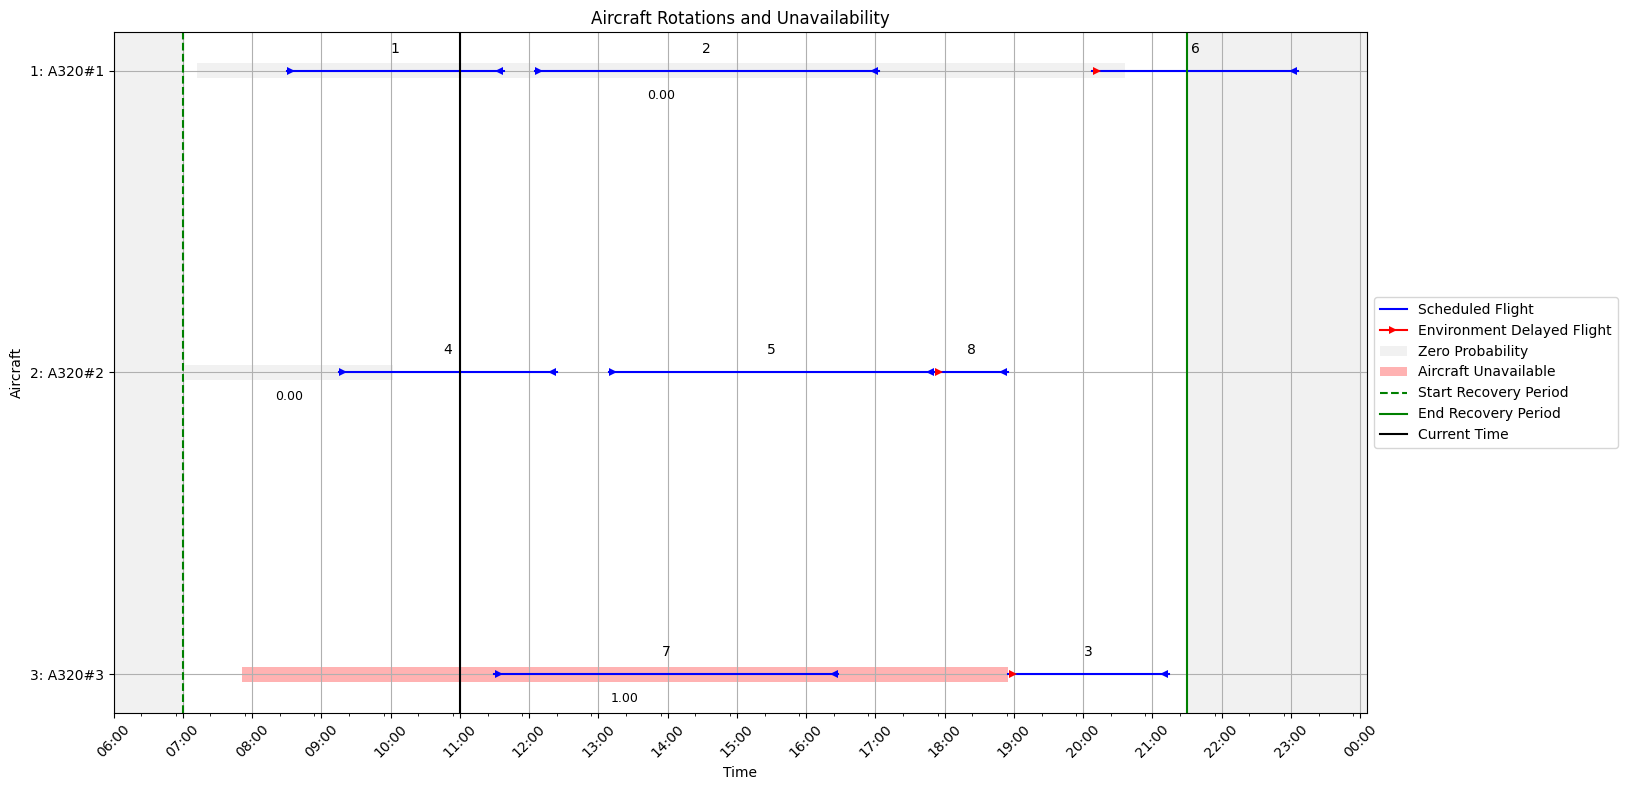


=== Starting schedule_flight_on_aircraft ===
Scheduling flight 2 on aircraft A320#1
Initial dep_time: 240.0, arr_time: None
Original departure minutes: 305.0
Flight duration: 298.0
****Current aircraft ID:
A320#1

Unavailability check:
Current aircraft: A320#1, Target aircraft: A320#1
Unavailability - Start: 12.0, End: 816.0, Prob: nan

Flight overlaps with unavailability period!
Flight times - Dep: 305.0, Arr: 603.0
Unavail times - Start: 12.0, End: 816.0
Case 2: Current aircraft with prob = 0.00 - Keeping original schedule
Final departure time for flight 2: 305.0 minutes.
Final arrival time for flight 2: 603.0 minutes.
Action taken: Flight 2, Aircraft 1, Reward: -1000



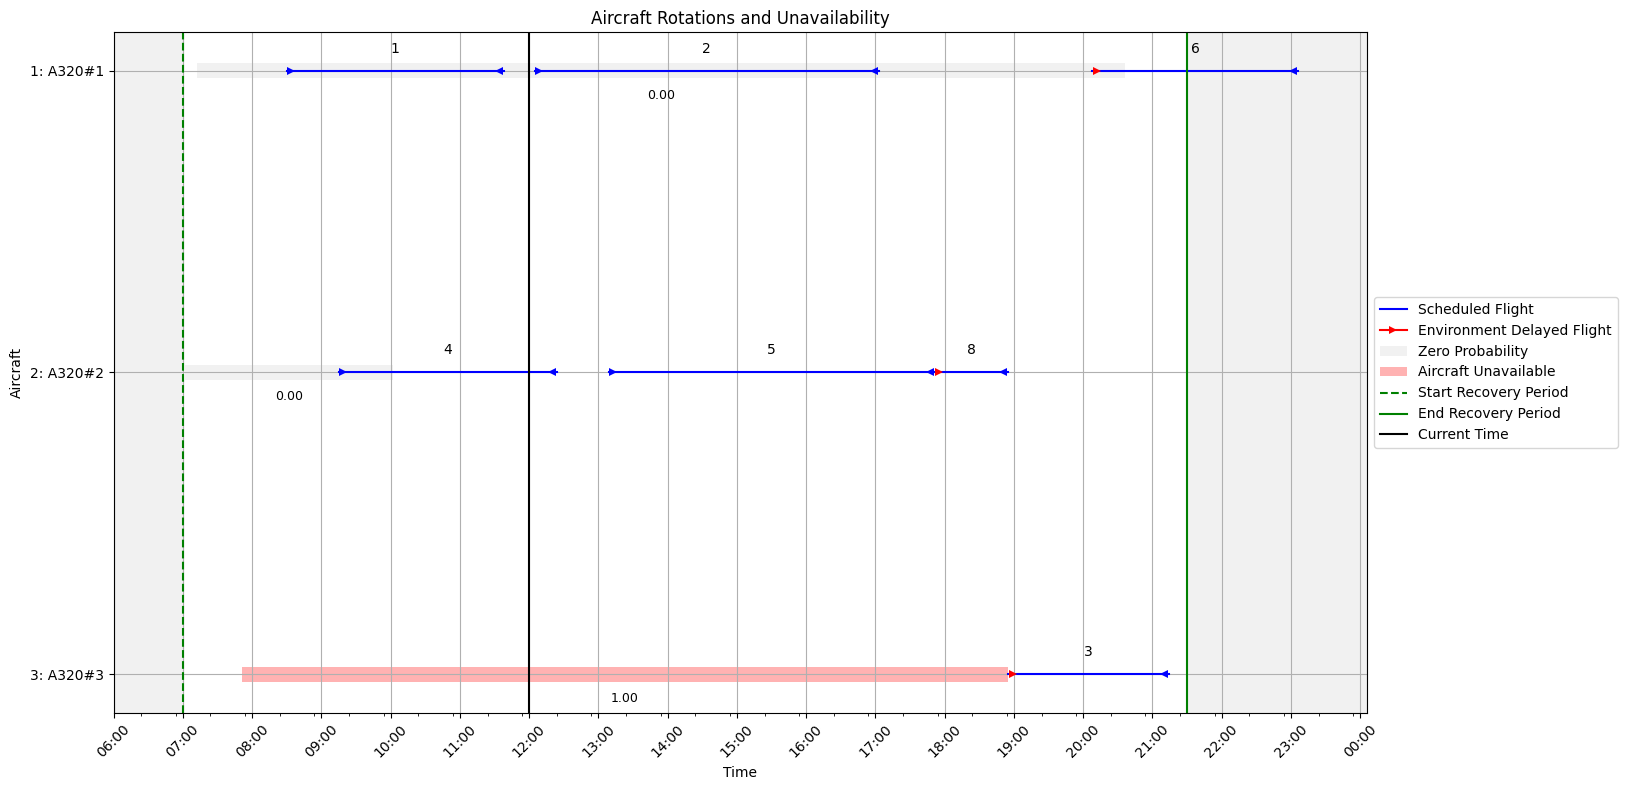

Total Reward: -1911.0


In [1]:
import os
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from datetime import datetime, timedelta
from src.environment import AircraftDisruptionEnv
from scripts.visualizations import StatePlotter
from src.config import TIMESTEP_HOURS
import time


env_type = "myopic"

# Run the random agent
def run_random_agent(scenario_folder):
    # Set a random seed based on current time
    current_seed = int(time.time())
    np.random.seed(current_seed)

    # Load the scenario data
    data_dict = load_scenario_data(scenario_folder)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize the environment
    env = AircraftDisruptionEnv(aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict,  env_type=env_type)
    # Removed DummyVecEnv wrapping

    # Reset the environment
    obs, info = env.reset()
    if DEBUG_MODE_VISUALIZATION:
        print("Observation keys:", obs.keys())

    done = False
    total_reward = 0
    step_num = 0

    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=env.aircraft_dict,
        flights_dict=env.flights_dict,
        rotations_dict=env.rotations_dict,
        alt_aircraft_dict=env.alt_aircraft_dict,
        start_datetime=env.start_datetime,
        end_datetime=env.end_datetime,
        uncertain_breakdowns=env.uncertain_breakdowns,
    )

    # Print state nicely
    print("Initial State:")
    print_state_nicely_proactive(env.state)

    while not done:
        # Visualize the environment at each step
        print(f"Step {step_num}:")

        # Extract necessary information from the environment for plotting
        swapped_flights = env.swapped_flights
        environment_delayed_flights = env.environment_delayed_flights
        current_datetime = env.current_datetime

        # Retrieve the updated dictionaries from the environment
        updated_flights_dict = env.flights_dict
        updated_rotations_dict = env.rotations_dict
        updated_alt_aircraft_dict = env.alt_aircraft_dict
        cancelled_flights = env.penalized_cancelled_flights

        if DEBUG_MODE_VISUALIZATION:
            print("Flights Dict:")
            print(updated_flights_dict)
            print("Alt Aircraft Dict:")
            print(updated_alt_aircraft_dict)
            print("Swapped Flights:")
            print(swapped_flights)
            print("Environment Delayed Flights:")
            print(environment_delayed_flights)
            print("Cancelled Flights:")
            print(cancelled_flights)
            print("Unavailabilities:")
            print(env.alt_aircraft_dict)
            print("Uncertain Breakdowns:")
            for key, value in env.uncertain_breakdowns.items():
                print(f"{key}: {value}")
            print("Current Breakdowns:")
            print(env.current_breakdowns)
            print("")

        # Update the StatePlotter's dictionaries with the updated ones
        state_plotter.alt_aircraft_dict = updated_alt_aircraft_dict
        state_plotter.flights_dict = updated_flights_dict
        state_plotter.rotations_dict = updated_rotations_dict

        # Plot the state using the updated dictionaries
        state_plotter.plot_state(
            updated_flights_dict, swapped_flights, environment_delayed_flights, cancelled_flights, current_datetime
        )


        # Get the action mask from the environment
        action_mask = obs['action_mask']

        # Convert observation to float32
        obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}

        # Select an action        
        valid_actions = np.where(action_mask == 1)[0]
        action_index = np.random.choice(valid_actions)  # Randomly select from valid actions

        # Step the environment
        obs, reward, terminated, truncated, info = env.step(action_index)  # Pass the scalar action index

        # Determine if the episode is done
        done = terminated or truncated

        # Accumulate the reward
        total_reward += reward

        # Print action taken and reward
        action = env.map_index_to_action(action_index)
        print(f"Action taken: Flight {action[0]}, Aircraft {action[1]}, Reward: {reward}")
        print("")

        step_num += 1

    # Final plot after the simulation ends
    state_plotter.plot_state(
        updated_flights_dict, swapped_flights, environment_delayed_flights, cancelled_flights, current_datetime+timedelta(hours=TIMESTEP_HOURS)
    )

    print(f"Total Reward: {total_reward}")


SCENARIO_FOLDER = "../Data/Testing/1k-3ac-12f-1dis-F/Scenario_04"
# SCENARIO_FOLDER = "../data/Example/Busy-scenario"

# Verify folder exists
if not os.path.exists(SCENARIO_FOLDER):
    raise FileNotFoundError(f"Scenario folder not found: {SCENARIO_FOLDER}")

# Run the random agent
run_random_agent(SCENARIO_FOLDER)
